# 1D parameter scan for cell signalling pathway 
nicole pagane
3/07/18

### import necessary modules

In [486]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as snt
from scipy.optimize import curve_fit
from numpy.linalg import svd
import os
import plotly.plotly as py
import plotly.graph_objs as go
from decimal import Decimal
from matplotlib.colors import LogNorm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [681]:
### SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
# K + K -> Kp + K  (k2)
# Kp+ K -> K + K   (k3)
# Kp+Kp -> Kpp+Kp  (k4)
# Kpp+Kp-> Kp+Kp   (k5)

fig = plt.figure(figsize=(10,8))

conc2 = 1
conc1 = 1


#equilibrium concentrations
S = np.mean([conc1, conc2])
Ktot = 10

Kp = np.linspace(0,Ktot,100)
Kpp = np.linspace(0,Ktot,100)

Ks = 0.001
theta = ((1+Ks)**2)/((1-2*Ks)**2) # k4k3/k2k5
print 'theta = ', theta

# kinetic rate constants
k1 = 1
k2 = 1
k3 = theta
k4 = theta
k5 = 1

# put new rate constants here that are solved for below
#k1 = 0.11367357151
#k2 = 0.166827441513
#k3 = 0.556330642514
#k4 = 0.558226680115
#k5 = 0.581486125119

#print 'assymetric factor =', (k4*k3)/(k2*k5)

#append to differential space
A = np.matrix(np.asarray([
                -k1, -k2, k3, 0, 0,
                k1, k2, -k3, -k4, k5, 
                0, 0, 0, k4, -k5 ]).reshape([3,5]))


theta =  1.00602106016


/Users/nicolepagane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning:

divide by zero encountered in log

/Users/nicolepagane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning:

divide by zero encountered in log

/Users/nicolepagane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning:

divide by zero encountered in log



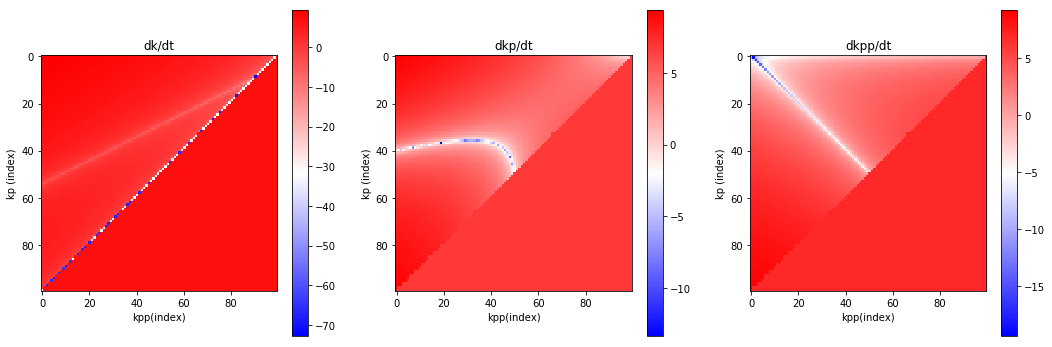

In [682]:
#find individual kinase differentials
dk = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
dkp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
dkpp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
for i in range(len(Kp)):
    for j in range(len(Kpp)):
        K = Ktot - Kp[i] - Kpp[j]
        if K >= 0:
            dk[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]**2,Kp[i]*Kpp[j]]).reshape([5,1])),2)[0]
            dkp[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]**2,Kp[i]*Kpp[j]]).reshape([5,1])),2)[1]
            dkpp[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]**2,Kp[i]*Kpp[j]]).reshape([5,1])),2)[2]

#plot
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,3,1)
plt.imshow(np.log(dk), cmap = 'bwr')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dk/dt')
plt.colorbar()
ax = fig.add_subplot(1,3,2)
plt.imshow(np.log(dkp), cmap = 'bwr')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dkp/dt')
plt.colorbar()
ax = fig.add_subplot(1,3,3)
plt.imshow(np.log(dkpp), cmap = 'bwr')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dkpp/dt')
plt.colorbar()

plt.show()


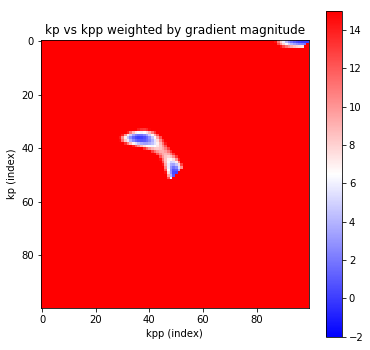

In [684]:
grad = dk + dkp + dkpp 

fig = plt.figure(figsize=(6,6))
plt.imshow(grad, cmap = 'bwr', vmax = 15, vmin = -2)
plt.xlabel('kpp (index)')
plt.ylabel('kp (index)')
plt.title('kp vs kpp weighted by gradient magnitude')
plt.colorbar()

plt.show()

In [685]:
#trace = go.Heatmap(z = np.log(grad.tolist()))
#data=[trace]
#py.iplot(data, filename='basic-heatmap')


In [686]:
#nullspace function courtesy of scipy
def nullspace(A, atol=1e-13, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

### plot dkpp/dt for the numerical solutions of the kinetic laws to determine best fit parameters

In [687]:
tol = 0.5
mins = []
inds = []
for i in range(np.shape(grad)[0]):
    for j in range(np.shape(grad)[1]):
        if grad[i,j] < tol:
            mins.append(grad[i,j])
            inds.append([i,j])
                
mins = np.asarray(mins)
print len(inds), 'combination found under', tol, 'tolerance'
for i in range(len(inds)):
    print Ktot - Kp[inds[i][0]] - Kpp[inds[i][1]], Kp[inds[i][0]], Kpp[inds[i][1]]

9 combination found under 0.5 tolerance
0.30303030303 0.0 9.69696969697
0.20202020202 0.0 9.79797979798
0.10101010101 0.0 9.89898989899
0.0 0.0 10.0
2.82828282828 3.63636363636 3.53535353535
2.72727272727 3.63636363636 3.63636363636
2.62626262626 3.63636363636 3.73737373737
0.10101010101 4.94949494949 4.94949494949
0.0 4.94949494949 5.05050505051


In [688]:
def nullparam(S,K,kp, kpp):
    mat = np.matrix([
            [-k1*S*K, -k2*K**2, k3*K*kp, 0, 0], 
            [k1*S*K, k2*K**2, -k3*K*kp, -k4*kp**2, k5*kp*kpp], 
            [0, 0, 0, k4*kp**2, -k5*kp*kpp]
              ])
    nullmat = nullspace(mat)
    for i in range(3):
        if len(nullmat) == sum(nullmat[:,i] > 0):
            return nullmat[:,i]
    return np.zeros(len(nullmat))

T = 10

def rates(y, t, k1, k2, k3, k4, k5, S):
    return np.asarray([-k1*S*y[0] - k2*y[0]**2 + k3*y[1]*y[0],
                      k1*S*y[0] + k2*y[0]**2 - k3*y[1]*y[0] - k4*y[1]**2 + k5*y[2]*y[1],
                      k4*y[1]**2 -  k5*y[2]*y[1]])

odeTrials = {}
acc = []
newinds = []
ind = 0
n = 100
t = np.linspace(0,T,n)
for i in range(len(inds)):
    temp = nullparam(S, Ktot - Kp[inds[i][0]] - Kpp[inds[i][1]], Kp[inds[i][0]], Kpp[inds[i][1]])
    y0 = [float(Ktot)/2,3*float(Ktot)/4,float(Ktot)/4]
    if sum(temp > 0):
        params = []
        for i in range(len(temp)):
            params.append(temp.tolist()[i][0])
        params.append(S)
        ode = snt.odeint(rates, y0,t, args = tuple(params))
        odeTrials[ind] = []
        odeTrials[ind] = ode
        acc.append(params)
        ind = ind+ 1

print ind

2


In [689]:
#create traces
data = []
for i in odeTrials.keys():
    trace = go.Scatter(
    y = odeTrials[i][:,2][0:n-1],
    x = t,
    mode = 'lines',
    #name = ''.join([str('%.2E' % Decimal(params['k3'][i])), ", ", str('%.2E' % Decimal(params['k4'][i],2)), 
     #  ", ", str('%.2E' % Decimal(params['k5'][i],2))])
    )
    data.append(trace)

py.iplot(data, filename='scatter-mode')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~peptime/0 or inside your plot.ly account where it is named 'scatter-mode'


In [690]:
#create traces
data = []
for i in odeTrials.keys():
    dkpp = np.diff(odeTrials[i][:,2])/np.diff(t)
    trace = go.Scatter(
    x = odeTrials[i][:,2][0:n-1],
    y = dkpp,
    mode = 'lines',
    #name = ''.join([str('%.2E' % Decimal(params['k3'][i])), ", ", str('%.2E' % Decimal(params['k4'][i],2)), 
     #              ", ", str('%.2E' % Decimal(params['k5'][i],2))])
    )
    data.append(trace)

py.iplot(data, filename='scatter-mode')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~peptime/0 or inside your plot.ly account where it is named 'scatter-mode'


In [691]:
for i in range(len(acc)):
    for j in range(len(acc[i])):
        print acc[i][j]
    print 'theta =',(acc[i][3]*acc[i][2])/(acc[i][1]*acc[i][4])
    print

print 'minimum threshold', theta

0.404662956472
0.397546349957
0.406991554863
0.504720608735
0.507759561883
1.0
theta = 1.01763153075

0.127310285917
0.517677425035
0.406441261644
0.530276655379
0.519051388885
1.0
theta = 0.80210406092

minimum threshold 1.00602106016


[0.4046629564718964, 0.39754634995734417, 0.40699155486281025, 0.5047206087352822, 0.5077595618826445, 1.0]
C0 : 0.30303030303 0.0 9.69696969697
C1 : 0.20202020202 0.0 9.79797979798
C2 : 0.10101010101 0.0 9.89898989899
C3 : 0.0 0.0 10.0
C4 : 2.82828282828 3.63636363636 3.53535353535
C5 : 2.72727272727 3.63636363636 3.63636363636
C6 : 2.62626262626 3.63636363636 3.73737373737
C7 : 0.10101010101 4.94949494949 4.94949494949
C8 : 0.0 4.94949494949 5.05050505051


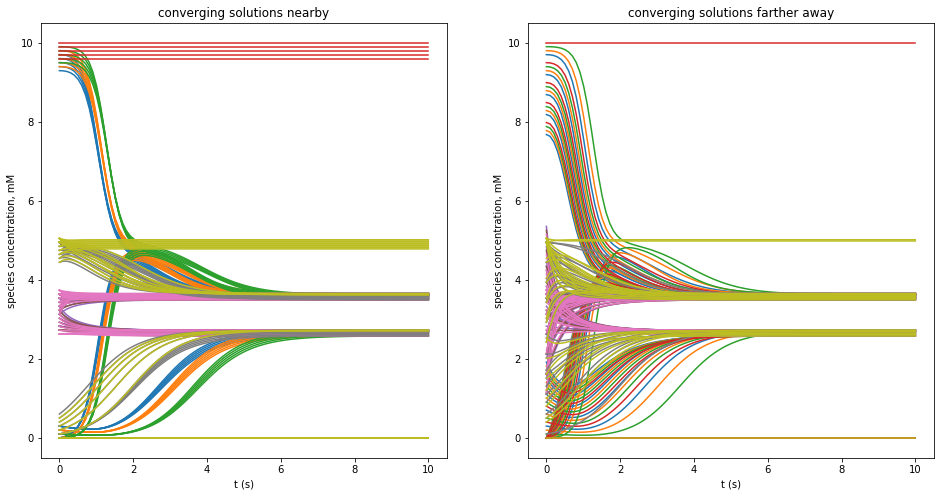

In [707]:
### see if kp, kpp combinations close to stable solution converge to stable solution
fig = plt.figure(figsize=(16,8))

chosen = 0
pts = 10
var = 5

params = []
for i in range(len(acc[chosen])):
    params.append(acc[chosen][i])
#params = [1,1,theta,theta,1, S]
print params

for iter in range(len(inds)):
    print ''.join(['C', str(iter % 10)]), ":", Ktot - Kp[inds[iter][0]] - Kpp[inds[iter][1]], Kp[inds[iter][0]], Kpp[inds[iter][1]]
    ind = 0
    initsNear = {}
    initsFar = {}
    for i in range(-pts/2, pts/2):
        if i < 0:
            att = inds[iter][0]+i
            if 0 <= att < len(Kp):
                initsNear[ind] = [Ktot - Kp[inds[iter][0]+i] - Kpp[inds[iter][1]], Kp[inds[iter][0]+i], Kpp[inds[iter][1]]]
            att = inds[iter][0]+var*i
            if 0 <= att < len(Kp):
                initsFar[ind] = [Ktot - Kp[inds[iter][0]+var*i] - Kpp[inds[iter][1]], Kp[inds[iter][0]+var*i], Kpp[inds[iter][1]]]
        else:
            att = inds[iter][1]-i
            if 0 <= att < len(Kpp):
                initsNear[ind] = [Ktot - Kp[inds[iter][0]+i] - Kpp[inds[iter][1]-i], Kp[inds[iter][0]], Kpp[inds[iter][1]-i]]
            att = inds[iter][1]-var*i
            if 0 <= att < len(Kpp):
                initsFar[ind] = [Ktot - Kp[inds[iter][0]+i] - Kpp[inds[iter][1]-var*i], Kp[inds[iter][0]], Kpp[inds[iter][1]-var*i]]
        ind = ind + 1

    odeNear = {}
    odeFar = {}
    n = 100
    t = np.linspace(0,T,n)
    for i in initsNear.keys():
        y0 = initsNear[i]
        ode = snt.odeint(rates, y0,t, args = tuple(params))
        odeNear[i] = []
        odeNear[i] = ode
    
    for i in initsFar.keys():
        y0 = initsFar[i]
        ode = snt.odeint(rates, y0,t, args = tuple(params))
        odeFar[i] = []
        odeFar[i] = ode
        
    ax = fig.add_subplot(1,2,1)
    for i in odeNear.keys():
        for j in range(np.shape(odeNear[i])[1]):
            plt.plot(t, odeNear[i][:,j][0:n], ''.join(['C', str(iter % 10)]))
    ax.set_xlabel('t (s)')
    plt.title('converging solutions nearby')
    ax.set_ylabel('species concentration, mM')

    ax = fig.add_subplot(1,2,2)
    for i in odeFar.keys():
        for j in range(np.shape(odeFar[i])[1]):         
            plt.plot(t, odeFar[i][:,j][0:n], ''.join(['C', str(iter % 10)]))
    ax.set_xlabel('t (s)')
    plt.title('converging solutions farther away')
    ax.set_ylabel('species concentration, mM')

plt.show()


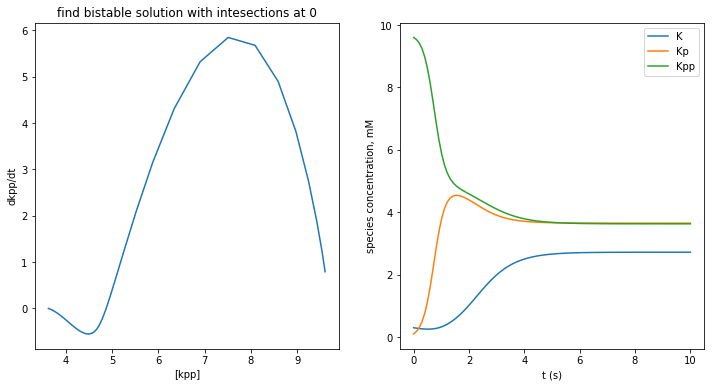

In [709]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
# K + K -> Kp + K  (k2)
# Kp+ K -> K + K   (k3)
# Kp+Kp -> Kpp+Kp  (k4)
# Kpp+Kp-> Kp+Kp   (k5)


#rate constants
k1 = params[0]
k2 = params[1]
k3 = params[2]
k4 = params[3]
k5 = params[4]

#initial concentrations
c1 = S
c2 = 0.3 #Ktot/2
c3 = 0.1 #3*Ktot/4
c4 = 9.6 #Ktot/4

V =1
y0 = np.asarray([c2, c3, c4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (k1, k2, k3, k4, k5, S))

#find dkpp/dt
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
dkpp = np.diff(ode[:,1])/np.diff(t)
ax.plot(ode[:,2][0:n-1],dkpp)
ax.set_title('find bistable solution with intesections at 0')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')


ax = fig.add_subplot(1,2,2)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['K', 'Kp', 'Kpp'])


plt.show()